<a href="https://www.kaggle.com/code/alihassanshahid/water-quality-monitoring-ml-model?scriptVersionId=199469872" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Water Quality Monitoring using Supervised Machine Learning
# 1.1 Intro

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data manipulation
import pandas as pd
import numpy as np

# Model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Machine learning models
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("/kaggle/input/water-quality-monitoring-dataset/brisbane_water_quality.csv")

In [3]:
df.head()

,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
0,2023-08-04 23:00:00,1468,4.834,73.484,1.621,NaN,20.018,NaN,7.472,NaN,101.175,NaN,8.176,NaN,35.215,NaN,53.262,NaN,2.068,NaN
1,2023-08-04 23:30:00,1469,2.544,106.424,1.959,NaN,19.986,NaN,7.455,NaN,100.884,NaN,8.175,NaN,35.209,NaN,53.254,NaN,1.994,NaN
2,2023-08-04 23:00:00,1470,1.260,156.755,1.620,NaN,20.001,NaN,7.430,NaN,100.571,NaN,8.171,NaN,35.207,NaN,53.252,NaN,2.030,NaN
3,2023-08-04 23:30:00,1471,0.760,281.754,1.761,NaN,19.983,NaN,7.419,NaN,100.398,NaN,8.171,NaN,35.211,NaN,53.257,NaN,1.973,NaN
4,2023-08-04 23:00:00,1472,3.397,244.637,1.635,NaN,19.986,NaN,7.429,NaN,100.538,NaN,8.171,NaN,35.208,NaN,53.253,NaN,1.944,NaN


In [4]:
df.shape

(30894, 20)

# 1.2 Impute Missing Values

In [5]:
# Missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

# Handle missing values: fill or drop
df = df.dropna()



Dissolved Oxygen (%Saturation) [quality]    5950
Dissolved Oxygen (%Saturation)              5749
Temperature [quality]                       5344
Temperature                                 5164
Dissolved Oxygen [quality]                  4524
Dissolved Oxygen                            4300
Salinity [quality]                          4182
Salinity                                    3958
Turbidity [quality]                         2224
Turbidity                                   2000
Specific Conductance [quality]              1591
Specific Conductance                        1367
pH [quality]                                1308
pH                                          1084
Chlorophyll [quality]                        808
Chlorophyll                                  585
Average Water Speed                           20
Average Water Direction                        1
dtype: int64


In [6]:
df.isnull().sum()

Timestamp                                   0
Record number                               0
Average Water Speed                         0
Average Water Direction                     0
Chlorophyll                                 0
Chlorophyll [quality]                       0
Temperature                                 0
Temperature [quality]                       0
Dissolved Oxygen                            0
Dissolved Oxygen [quality]                  0
Dissolved Oxygen (%Saturation)              0
Dissolved Oxygen (%Saturation) [quality]    0
pH                                          0
pH [quality]                                0
Salinity                                    0
Salinity [quality]                          0
Specific Conductance                        0
Specific Conductance [quality]              0
Turbidity                                   0
Turbidity [quality]                         0
dtype: int64

# 1.3 Removing Outliers

In [7]:
from scipy import stats

# Z-scores for detecting outliers
z_scores = stats.zscore(df.select_dtypes(include='number'))

# Threshold for outliers (you can set it to 3 standard deviations)
outliers = (z_scores > 3).sum(axis=1)
outlier_rows = df[outliers > 0]
print(outlier_rows)

# You can visualize outliers using boxplots as well (as shown earlier).


                 Timestamp  Record number  Average Water Speed  \
230    2023-08-09 15:30:00           1698                3.287   
231    2023-08-09 16:00:00           1699                6.118   
251    2023-08-10 02:00:00           1719                2.513   
260    2023-08-10 06:30:00           1728                0.608   
263    2023-08-10 08:00:00           1731                4.691   
...                    ...            ...                  ...   
28692  2024-06-12 04:40:00          30160               58.215   
28990  2024-06-14 06:00:00          30458               56.093   
30103  2024-06-21 22:10:00          31571               70.008   
30713  2024-06-26 03:10:00          32181               67.262   
30718  2024-06-26 04:00:00          32186               72.360   

       Average Water Direction  Chlorophyll  Chlorophyll [quality]  \
230                    229.265        2.848                 1020.0   
231                    146.147        2.744                 1020.0 

# 1.4 Data Visualizations

## 1.4.1 Polar plot for water direction and speed

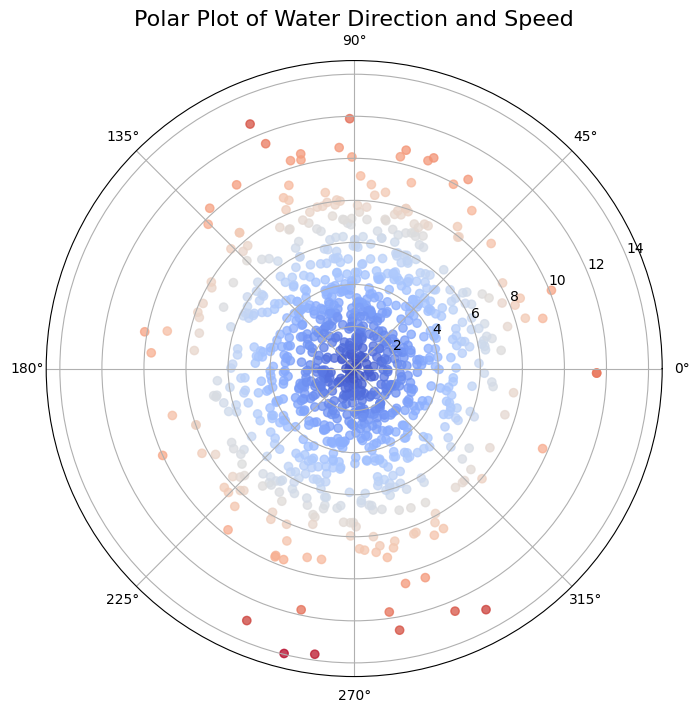

In [8]:
# Polar plot for water direction and speed
df_sample = df.head(1000)  # For readability, use a sample

plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# Convert degrees to radians for plotting
angles = np.deg2rad(df_sample['Average Water Direction'])
speeds = df_sample['Average Water Speed']

# Create the polar plot
ax.scatter(angles, speeds, c=speeds, cmap='coolwarm', alpha=0.75)
ax.set_title('Polar Plot of Water Direction and Speed', fontsize=16)
plt.show()


## 1.4.2 Violin plot comparing 'Chlorophyll' values based on quality

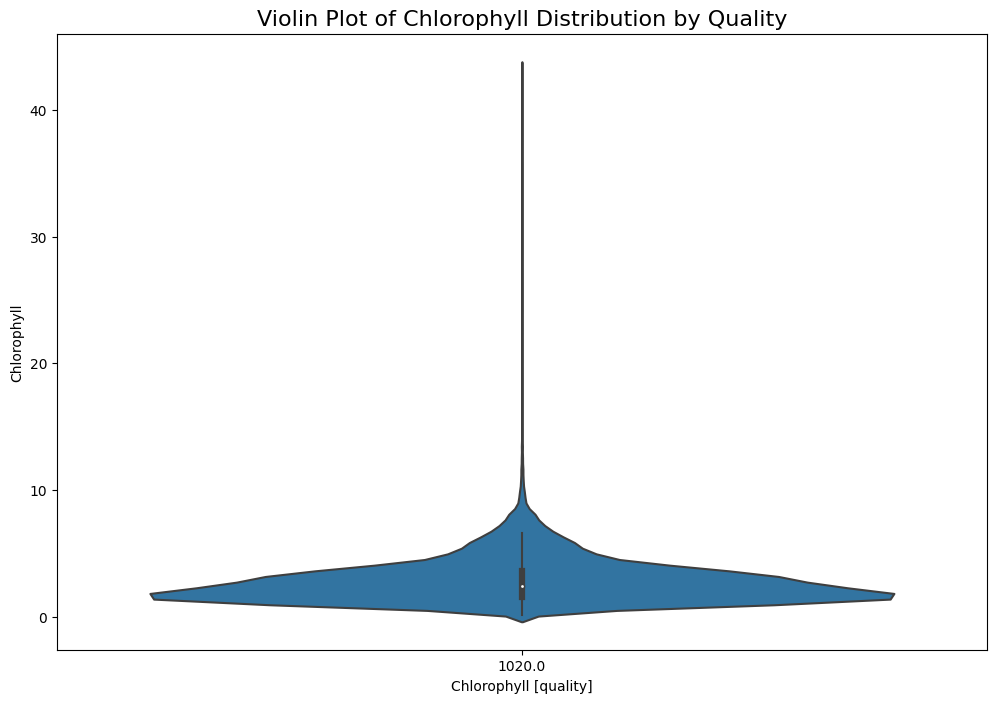

In [9]:
# Violin plot comparing 'Chlorophyll' values based on quality
plt.figure(figsize=(12, 8))
sns.violinplot(x='Chlorophyll [quality]', y='Chlorophyll', data=df, split=True)
plt.title('Violin Plot of Chlorophyll Distribution by Quality', fontsize=16)
plt.show()


## 1.4.3 Network Graph (In Progress)

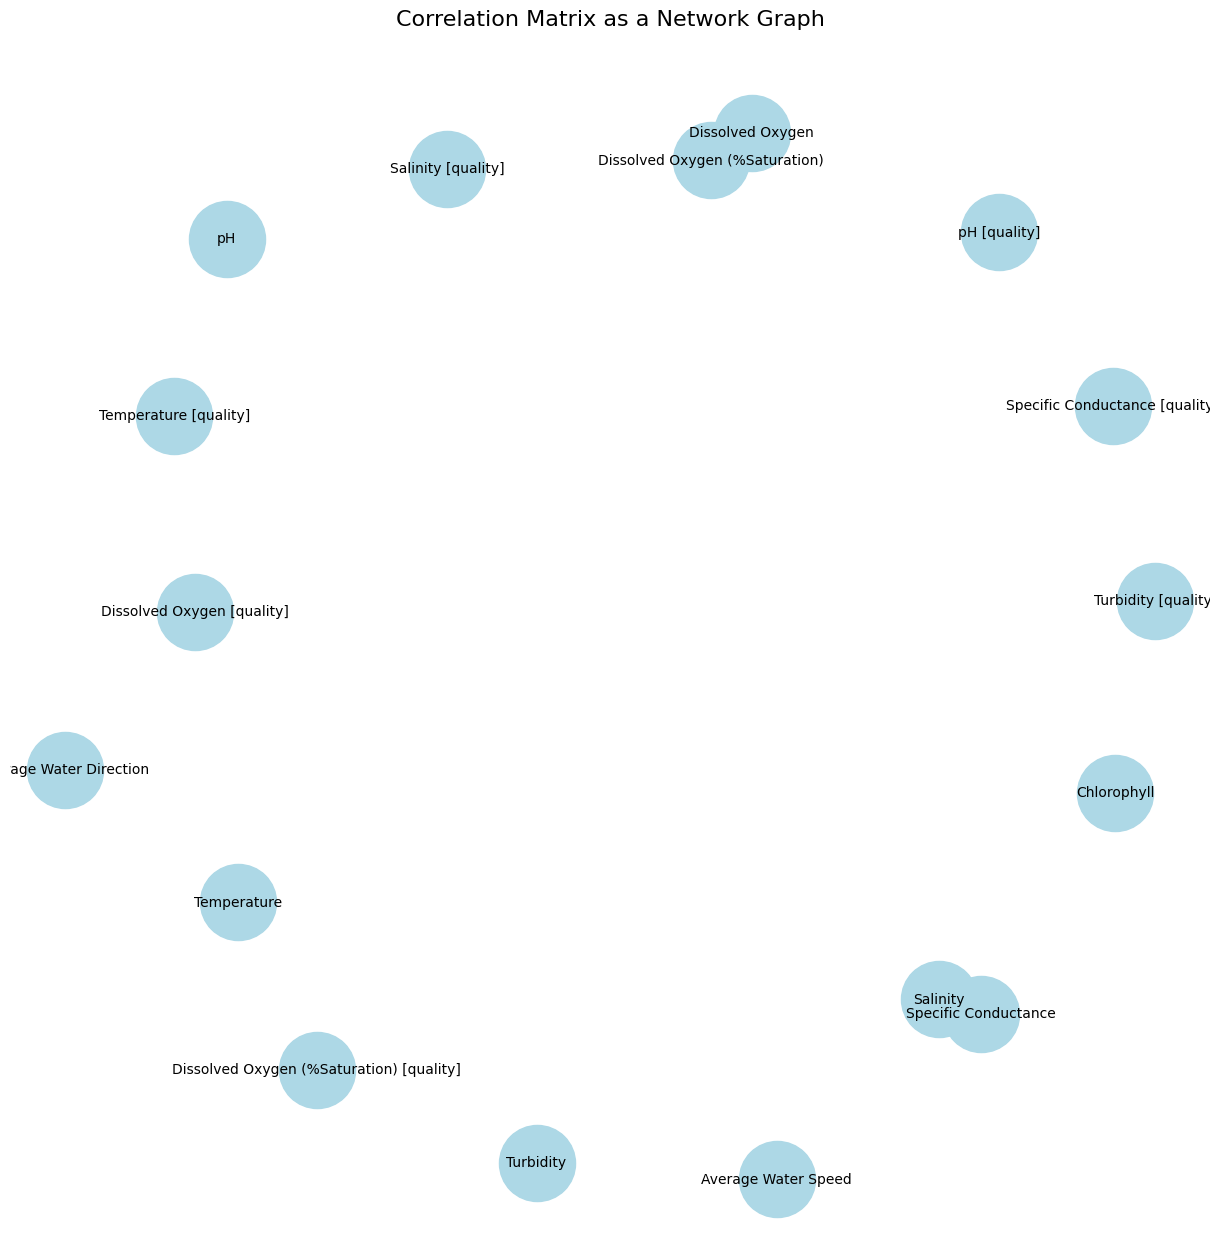

In [10]:
import networkx as nx

# Drop non-numeric columns for correlation calculation
numeric_df = df.drop(columns=['Timestamp', 'Record number', 'Chlorophyll [quality]'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a network graph from the correlation matrix
G = nx.Graph()

# Add nodes
for col in corr_matrix.columns:
    G.add_node(col)

# Add edges (only strong correlations for clarity)
threshold = 0.6
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Positions the nodes
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10)
nx.draw_networkx_edges(G, pos, width=[d['weight'] * 5 for (u, v, d) in edges], edge_color='grey')
plt.title('Correlation Matrix as a Network Graph', size=16)
plt.show()


## 1.4.4 Histogram for numeric values

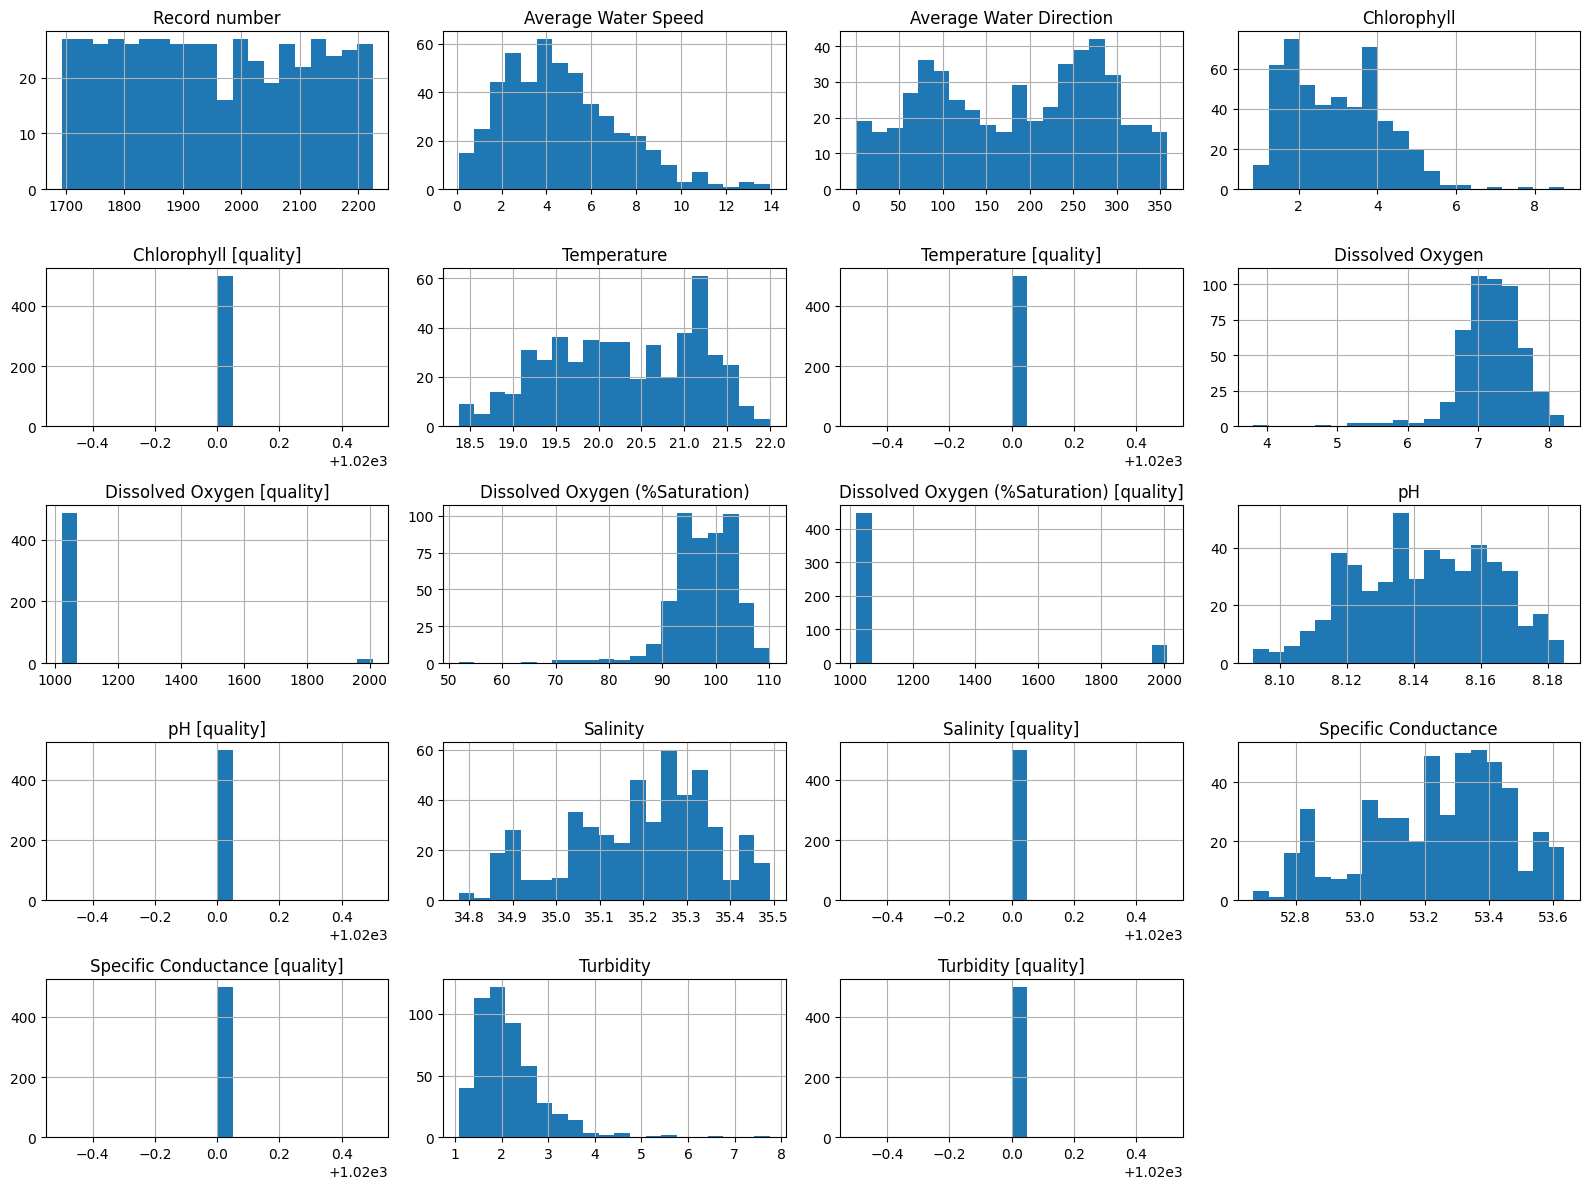

In [11]:
df_sample = df.head(500)
# Plot histograms for each numeric column
df_sample.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()


## 1.4.5 Boxplot to visualize outliers (In Progress)

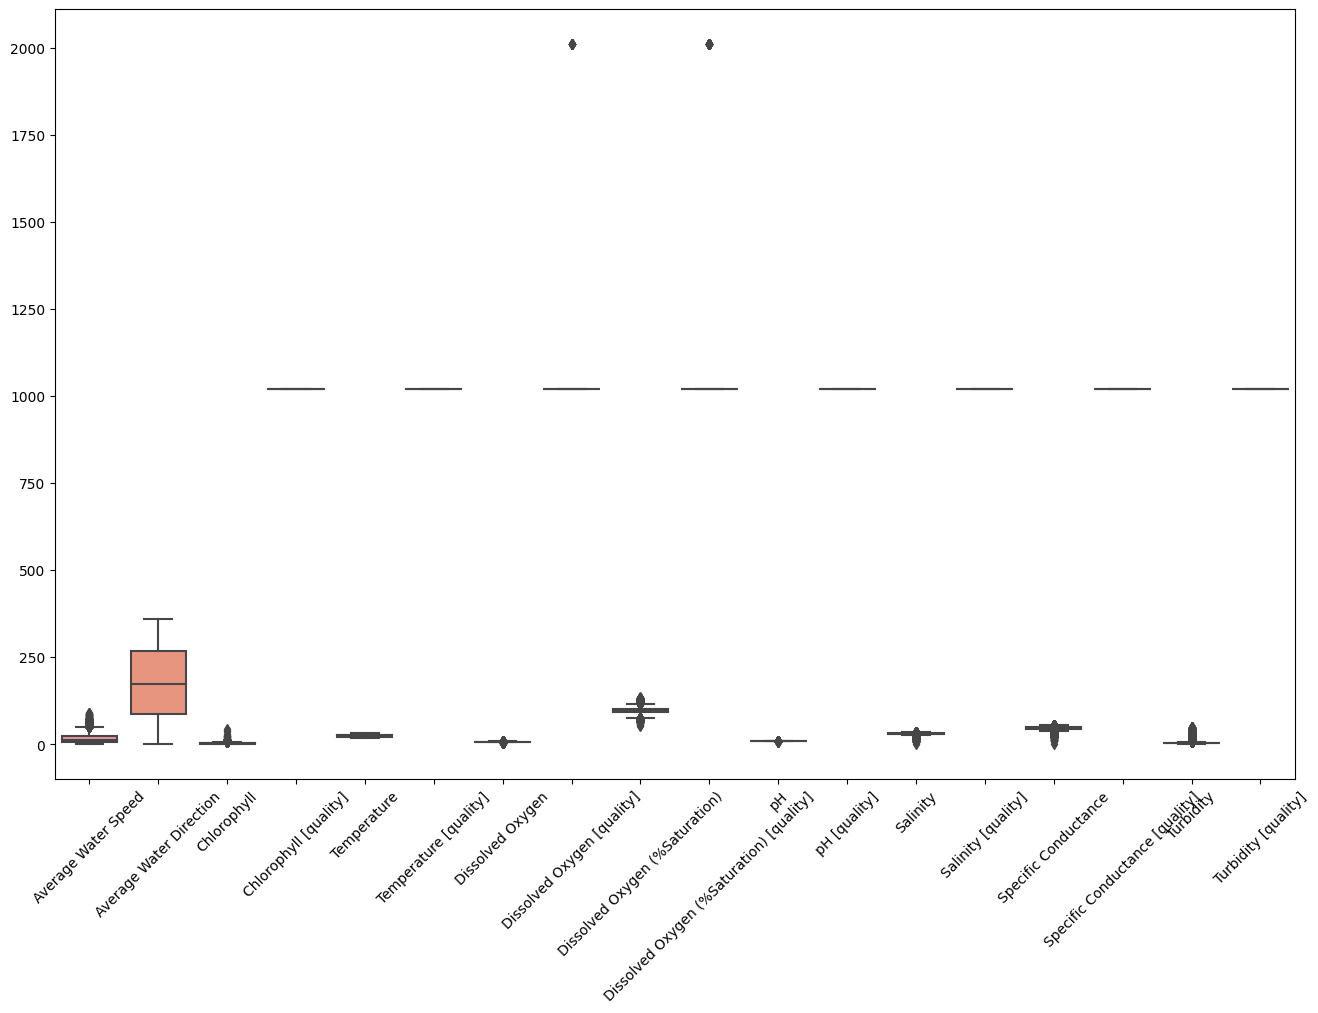

In [12]:
# Boxplot to visualize outliers for each variable
plt.figure(figsize=(16, 10))
sns.boxplot(data=df.drop(columns=['Timestamp', 'Record number']))
plt.xticks(rotation=45)
plt.show()

## 1.4.6 Time Series Analysis 

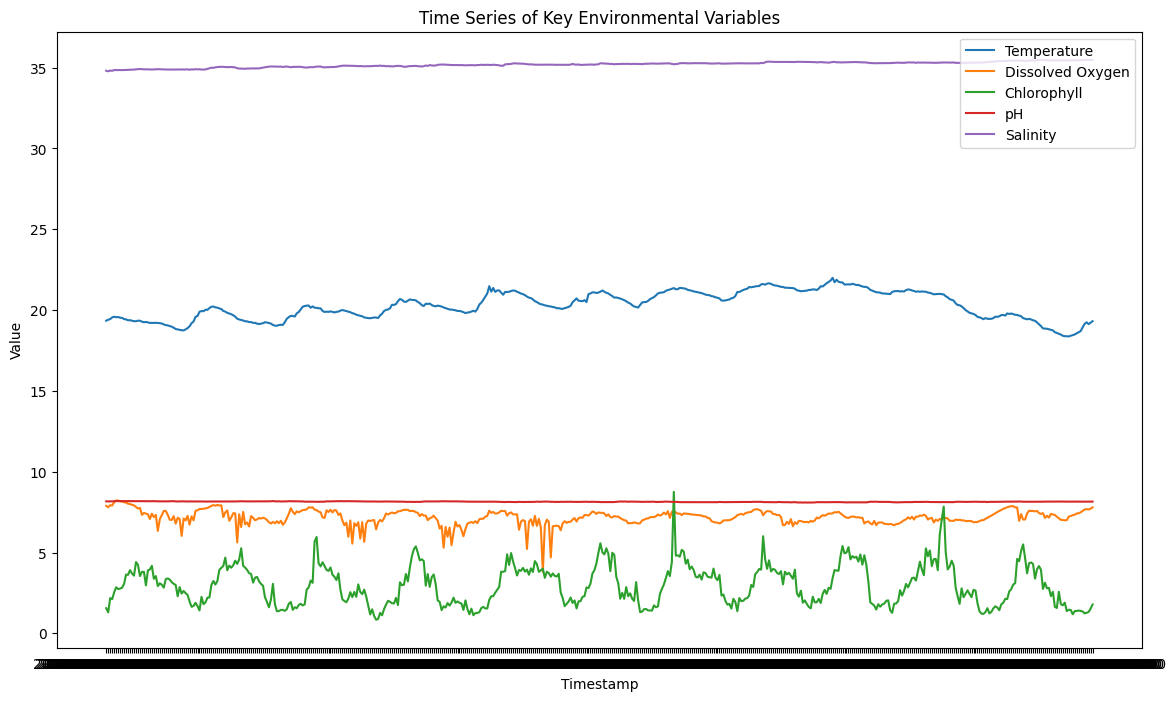

In [13]:
# Convert timestamp to datetime if it’s not already
df_sample = df.head(500)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Plot time-series for key variables
plt.figure(figsize=(14, 8))
for col in ['Temperature', 'Dissolved Oxygen', 'Chlorophyll', 'pH', 'Salinity']:
    plt.plot(df_sample['Timestamp'], df_sample[col], label=col)

plt.legend()
plt.title('Time Series of Key Environmental Variables')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()


## 1.4.7 3D plot: Temperature vs Salinity vs Time

/tmp/ipykernel_36/2656972006.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Timestamp'] = pd.to_datetime(df_sample['Timestamp']).astype(int) / 10**9


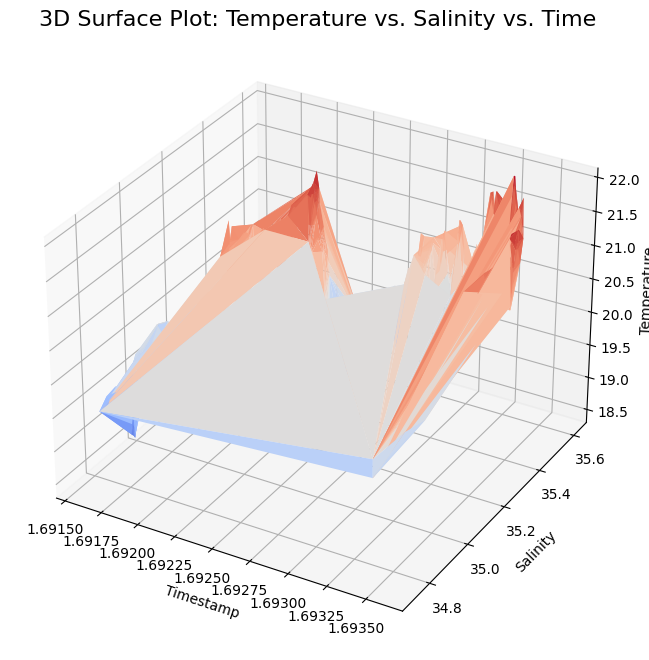

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the first 1000 rows to prevent clutter
df_sample = df.head(1000)

# Convert Timestamp to a numerical value (e.g., seconds since epoch)
df_sample['Timestamp'] = pd.to_datetime(df_sample['Timestamp']).astype(int) / 10**9

# Drop duplicates if necessary
df_sample = df_sample.drop_duplicates(subset=['Timestamp', 'Salinity', 'Temperature'])

# Create a 3D plot
ax.plot_trisurf(df_sample['Timestamp'], df_sample['Salinity'], df_sample['Temperature'], cmap='coolwarm', linewidth=0.2)

ax.set_title('3D Surface Plot: Temperature vs. Salinity vs. Time', fontsize=16)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Salinity')
ax.set_zlabel('Temperature')
plt.show()


# 1.5 Supervised ML implementation

In [15]:
df.shape

(19149, 20)

In [19]:
# Drop columns with quality information
df = df.drop(columns=['Dissolved Oxygen [quality]', 'Chlorophyll [quality]', 'Temperature [quality]', 
                      'Dissolved Oxygen (%Saturation) [quality]', 'pH [quality]', 'Salinity [quality]',
                      'Specific Conductance [quality]', 'Turbidity [quality]'], errors='ignore')

In [20]:
df.head()

,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
225,2023-08-09 13:00:00,1693,5.314,50.605,1.557,19.346,7.885,105.210,8.169,34.809,52.714,2.085
226,2023-08-09 13:30:00,1694,5.088,34.550,1.299,19.404,7.804,104.222,8.162,34.776,52.668,2.296
227,2023-08-09 14:00:00,1695,5.836,154.556,2.182,19.443,7.930,106.005,8.169,34.822,52.730,2.081
228,2023-08-09 14:30:00,1696,1.530,17.843,2.112,19.549,7.912,105.963,8.165,34.808,52.712,2.291
229,2023-08-09 15:00:00,1697,6.343,78.149,2.539,19.591,8.113,108.773,8.178,34.850,52.769,2.014


In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define target and features
y = df['Dissolved Oxygen']
X = df[['Average Water Speed', 'Average Water Direction', 'Chlorophyll', 'Temperature', 
          'Salinity', 'Specific Conductance', 'Turbidity']]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.1314
